# Signal processing of GRACE satellite data

The GRACE satellite data has been used for more than a decade to investigate the global-scale mass redistribution since April 2002.
With the Follow-on mission which had recently (5/22/2018) been launched, the extended measurement is truly an important achievement in the field of Earth geodesy, hydrology, and cryosphere.

To make use of this incredible dataset, one must know first what are the data currently out there. 
There are three processing centers that provides the GRACE data retrieval.
The three centers are CSR (Center of Space Research) at UT-Austin, GFZ (Deutsches GeoForschungsZentrum) at Potsdom, Germany, and JPL (Jet Propulsion Laboratory) at NASA/Caltech.
Each processing center provides the gravitational anomaly on the Earth from the retrieval, which can be further transformed to mass anomaly.
Gravitational anomaly derivded from different centers also provide an opportunity for an inter-comparison on the different processing applied during the retrieval.

Besides different centers, there are two kinds of solution available nowadays. One is in the form of Stoke's coefficients (spherical harmonic coefficients - will refer to it as SH below) which represents the gravitational anomaly in the spectral domain. This representation provides a easier way to compare with the measured geoid anomaly in the past, which is usually in this format. The other is in the form of gridded data (mass concentration block - will refer to it as MASCON below) which reprsents the mass anomaly in the spatial domain. This representation is considered easier to understand and to used by the scientist who only wants to understand the mass anomaly changes at a specific location on the Earth. Both products has its merit and problem. For detail derivation, one can take a look at the [Wahr and Molenaar, 1998](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/98JB02844) for SH solution and [Watkins et al., 2015](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014JB011547) for MASCON solution. 

To make use of the data, one also need to understand some of the errors that might be generated during the processing steps or post-processing steps. From here on, I will mainly use the SH solution to demostrate the possible effect or error in the gravitational/mass anomaly solutions. Some of the effect or error are also applicable to the MASCON solutions just that the method to deal with it is different. 


Let's first take a look at the solution that downloaded directly from the [PODAAC/NASA ftp server](ftp://podaac.jpl.nasa.gov/allData/grace/L2). On the same ftp server, you can also find a [doc directory](ftp://podaac.jpl.nasa.gov/allData/grace/docs/) providing various explanation related to the dataset. 
The first three letters provide the covered area. EX: **GSM** (the one we are using) is the global solution with atmospheric and non-tidal dynamic ocean signal removed, **GAD** (also the one we are using) is the solution only contain the non-tidal dynamic ocean signal. The folloing numbers **YYYYDDD-YYYYDDD** represent period of the observation where **YYYY** is year and  **DDD** is days in one year. The rest is mainly related to the processing center id and the version of the solutions. 

The data is in ascii format so it is easy to open with any text editor. Here, I will load the data using *python pandas package* to demostrate the data structure. 

In [11]:
import pandas as pd
import numpy as np
from datetime import datetime 

### Read the dataset

In [20]:
f = open('GSM-2_2015345-2016003_0024_UTCSR_0060_0005', 'r')
i=0
lines=[]
for line in f :
    i+=1
    line.split()
    if i > 6:                               # skip the header info
        lines.append(line.split()[1:1+6])   # only need the col 2~9

nelements=len(lines[0])
nlines=len(lines)
data=np.array(lines,dtype=np.float64)      

### Create the timestamp during the measurement period

In [50]:
start,end=np.array(line.split()[7:9], dtype=float)
start=int(start)
end=int(end)
tstamp=[]
i=0
for time in [start,end]:
    year=time/10000
    mon=time/100-year*100
    day=time-year*10000-mon*100
    tstamp.append(datetime(year,mon,day))
    i+=1
print tstamp

[datetime.datetime(2015, 12, 11, 0, 0), datetime.datetime(2016, 1, 4, 0, 0)]


### Saved as DataFrame

In [45]:
gsm=pd.DataFrame(data,columns=['l','m','clm','slm','errclm','errslm'])

In [46]:
gsm.head(5)

,l,m,clm,slm,errclm,errslm
0,0.0,0.0,1.000000e+00,0.0,0.000000e+00,0.0
1,1.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0
2,2.0,0.0,-4.841695e-04,0.0,1.711000e-11,0.0
3,3.0,0.0,9.570992e-07,0.0,1.147000e-12,0.0
4,4.0,0.0,5.398711e-07,0.0,5.737000e-13,0.0


### Sparsity of the spherical harmonic coefficients

Storing the dataset in this form saves both memory and storage space due to the nature of spherical harmonic coefficients. To demostrate the sparse matrix if one want to store the degree (`l`) and order (`m`) in a matrix of size `[l,m]`, I transform the dataframe to matrix. The plot is showing the 2-D heatmap of the matrix to show the sparsity of the matrix. 

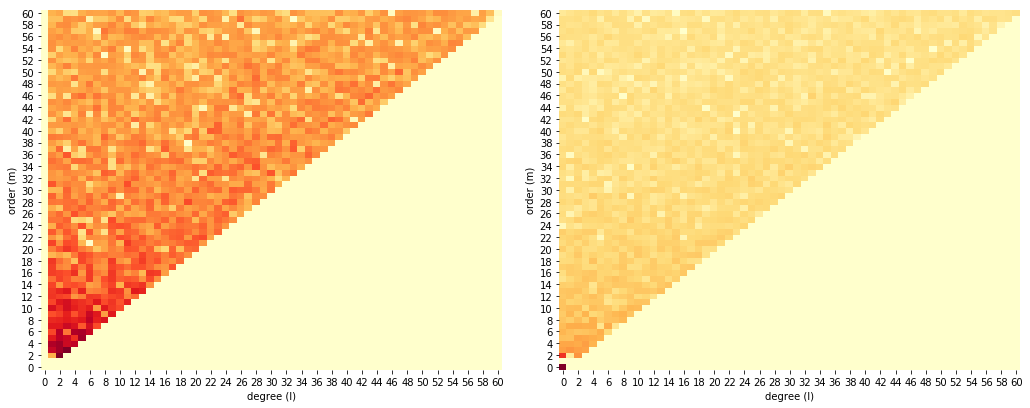

In [125]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

def toMatrix(x,y,data):
    nx=int(np.max(x)+1)
    ny=int(np.max(y)+1)
    matrix=np.zeros([nx,ny],dtype=np.float64)
    for i in range(len(x)):
        matrix[int(x[i]),int(y[i])]=data[i]
    return matrix

slm=toMatrix(gsm.l,gsm.m,gsm.slm)
slmamp=np.abs(slm)
clm=toMatrix(gsm.l,gsm.m,gsm.clm)
clmamp=np.abs(clm)

fig=plt.figure(figsize=[8,5])
ax1=fig.add_axes([0,0,0.8,1])
ax2=fig.add_axes([0.9,0,0.8,1])

sns.heatmap(slmamp,norm=colors.SymLogNorm(linthresh=1E-10
            ,vmin=slmamp.min(), vmax=slmamp.max()),cmap='YlOrRd',cbar=False,ax=ax1)
sns.heatmap(clmamp,norm=colors.SymLogNorm(linthresh=1E-10
            ,vmin=clmamp.min(), vmax=clmamp.max()),cmap='YlOrRd',cbar=False,ax=ax2)

ax1.set_xlabel('degree (l)')
ax1.set_ylabel('order (m)')
ax1.invert_yaxis()
ax2.set_xlabel('degree (l)')
ax2.set_ylabel('order (m)')
ax2.invert_yaxis()

As one can see, only half of the matrix is occupied. In other words, falf of the matrix is just storing the value zeros which can be really redundant.

---

### Convert the spherical harmonics to the spatial domain 

This part is following the equation 9 in [Wahr and Molenaar, 1998](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/98JB02844) 

$$\Delta \sigma (\theta,\phi)=\alpha\rho_w \sum^\infty_{l=0}\sum^l_{m=0} \tilde{P}_{lm}(\cos \theta)
(\Delta \hat{C}_{lm} \cos(m\phi)+\Delta \hat{S}_{lm} \sin(m\phi))$$

where $\sigma$ represent the surface mass density in $kg/m^2$, $\theta$ and $\phi$ are the longitude and the colatitude in radians respectively, $\alpha$ is the Earth radius in $m$, $\rho_w$ is the water density in $kg/m^3$, $\tilde{P}_{lm}$ is the assoicated Legendre polynomials, and $\hat{C}_{lm}$ and $\hat{S}_{lm}$ are the spherical harmonic coefficients.  

Though the equation seems a little intimidating, there is only two things we need to focus on. The rest of the symbols are all constant or function we can directly determined.
* The $\Delta$ symbol 
* The $\hat{C}_{lm}$ and $\hat{S}_{lm}$ which is the spherical harmonic coefficients representing the surface mass density


Due to the setup of the GRACE satellite data, it can only observed the changes relative to a certain mean value. Therefore, the $\Delta$ value can change based on the mean value one choose to removed. Usually, we can simply subtract the mean value over the period of study, which $\Delta$ value would than represent the anomalies over the period. 

Spherical harmonic coefficients of the surface mass density unforturnatly cannot be observed by GRACE. The data that we just downloaded is the Spherical harmonic coefficients of the representing the geoid height changes (a equi-geopotential height changes). Furturnately, by assuming the geoid height can only be reflected by the mass changes at the Earth surface in the form of water and the associated elastic rebound, there is a simply convertiong between the two physical variables. 


